In [1]:
!pip install snntorch umap-learn seaborn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


Using: cuda

Config: K3x3_C4_16
Files already downloaded and verified
Files already downloaded and verified

--- Training Baseline (CNN-SNN) ---
Epoch [1/50] Loss: 2.0330 Train Acc: 26.20% Test Acc: 37.61%
Epoch [2/50] Loss: 1.7493 Train Acc: 37.37% Test Acc: 42.62%
Epoch [3/50] Loss: 1.6359 Train Acc: 40.97% Test Acc: 45.15%
Epoch [4/50] Loss: 1.5793 Train Acc: 42.56% Test Acc: 46.55%
Epoch [5/50] Loss: 1.5371 Train Acc: 44.39% Test Acc: 47.44%
Epoch [6/50] Loss: 1.4995 Train Acc: 45.77% Test Acc: 48.23%
Epoch [7/50] Loss: 1.4723 Train Acc: 46.58% Test Acc: 49.67%
Epoch [8/50] Loss: 1.4461 Train Acc: 47.95% Test Acc: 50.65%
Epoch [9/50] Loss: 1.4269 Train Acc: 48.53% Test Acc: 51.86%
Epoch [10/50] Loss: 1.4033 Train Acc: 49.61% Test Acc: 52.22%
Epoch [11/50] Loss: 1.3942 Train Acc: 50.11% Test Acc: 52.33%
Epoch [12/50] Loss: 1.3693 Train Acc: 51.00% Test Acc: 54.52%
Epoch [13/50] Loss: 1.3556 Train Acc: 51.31% Test Acc: 53.64%
Epoch [14/50] Loss: 1.3490 Train Acc: 52.02% Test Acc: 55.

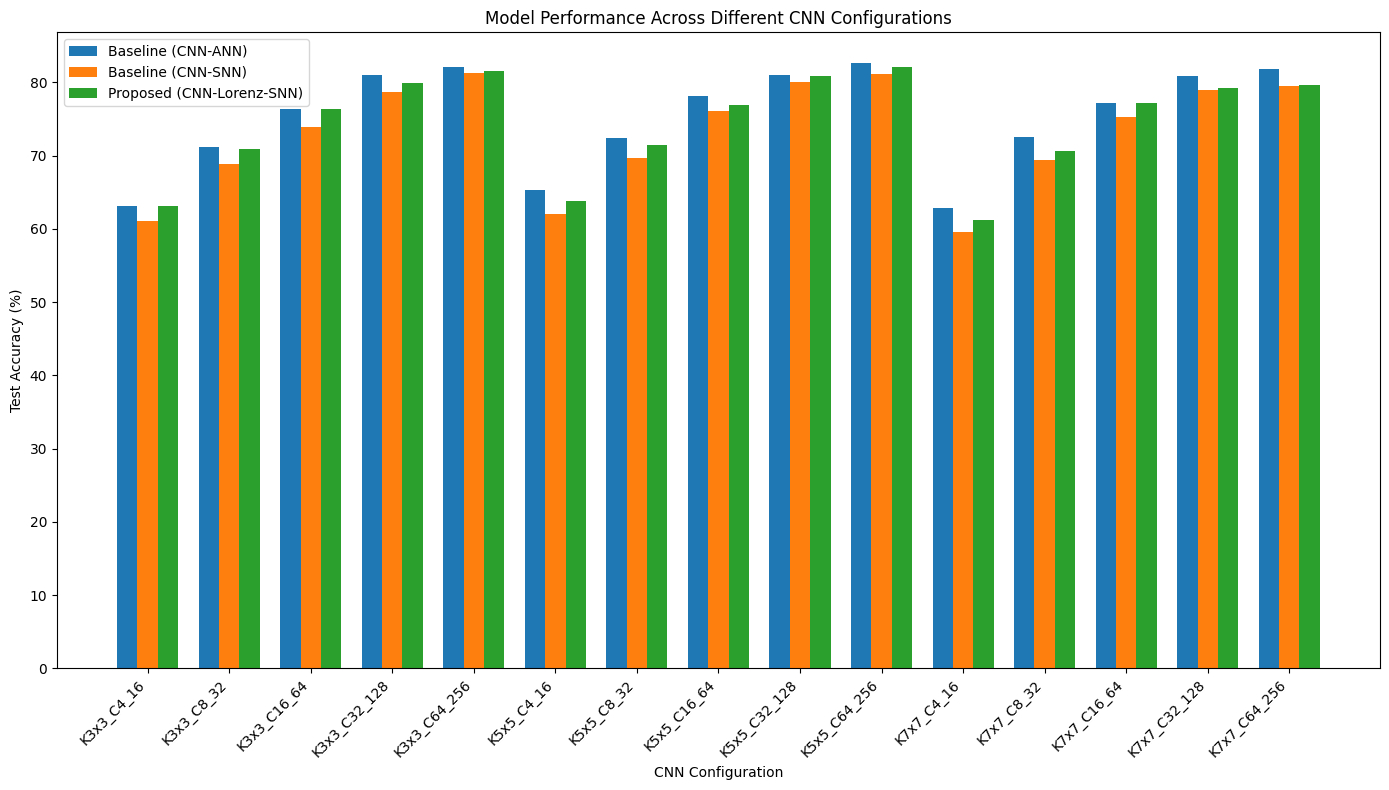

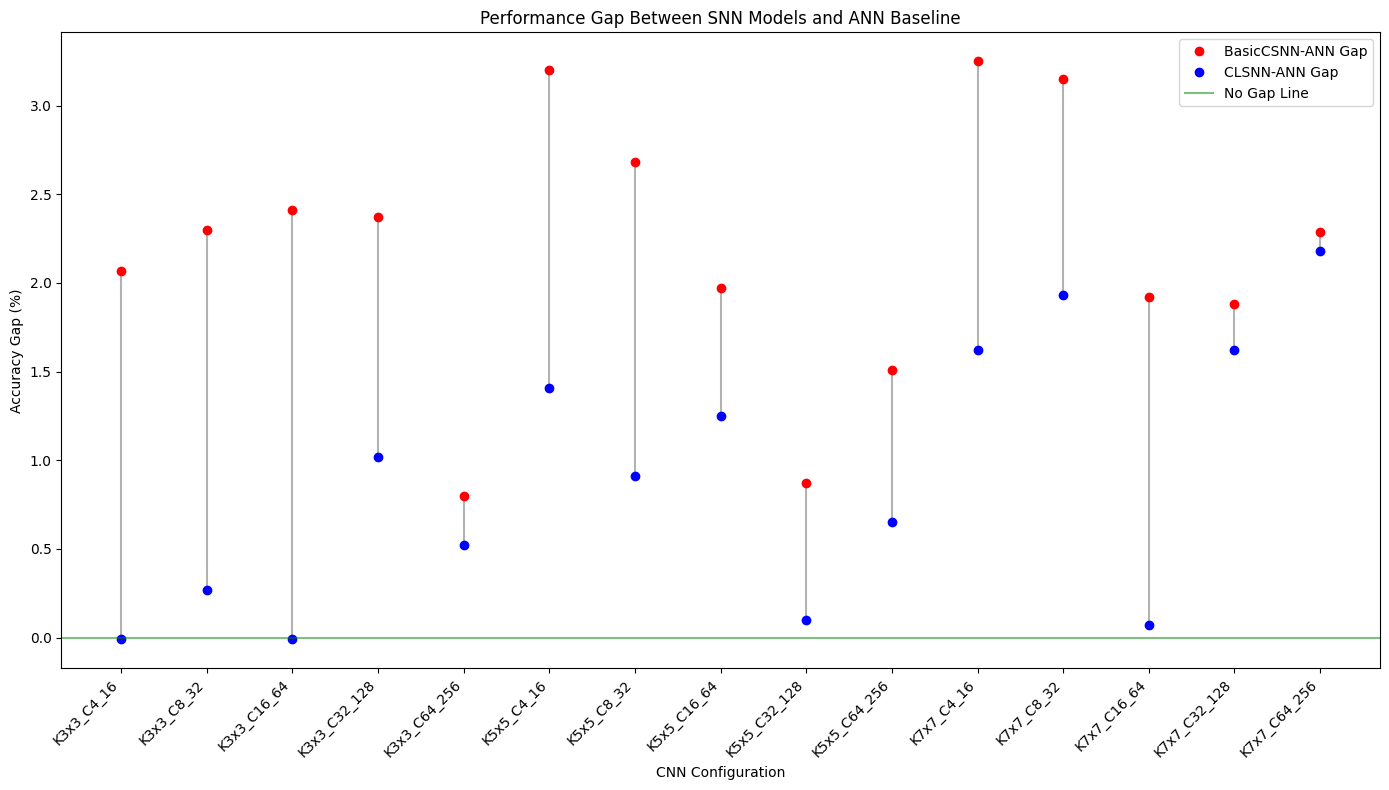

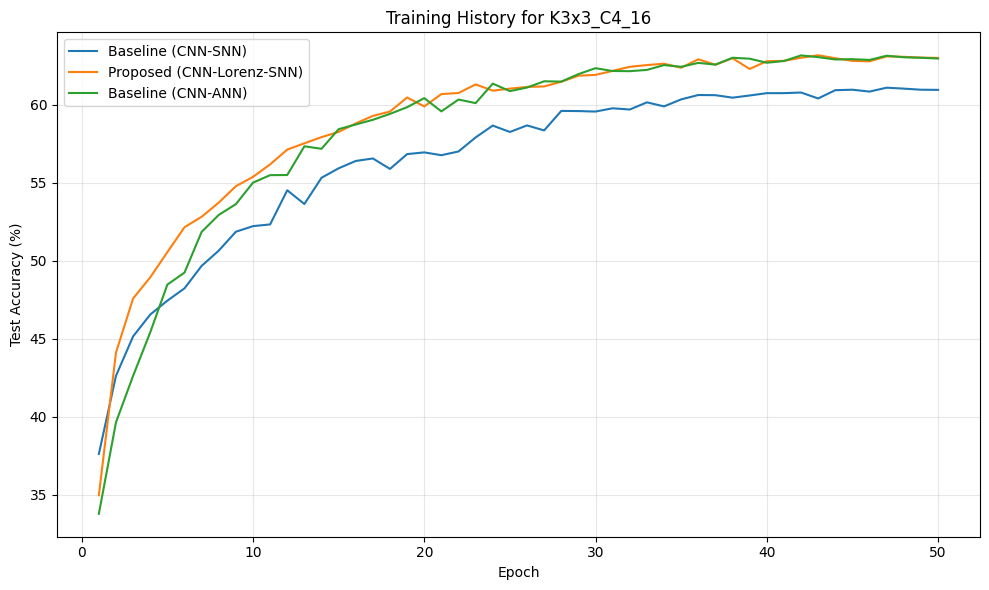

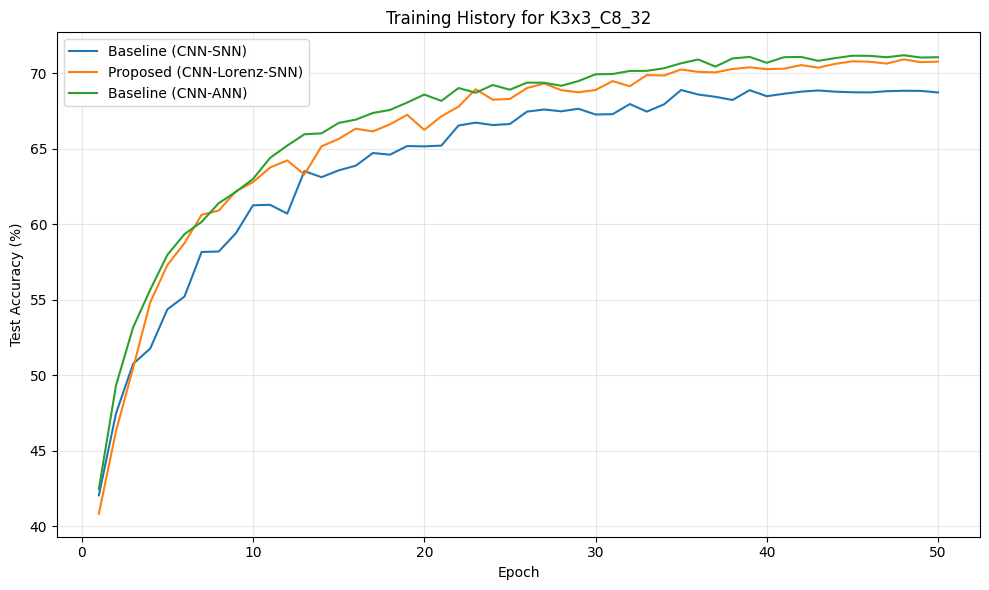

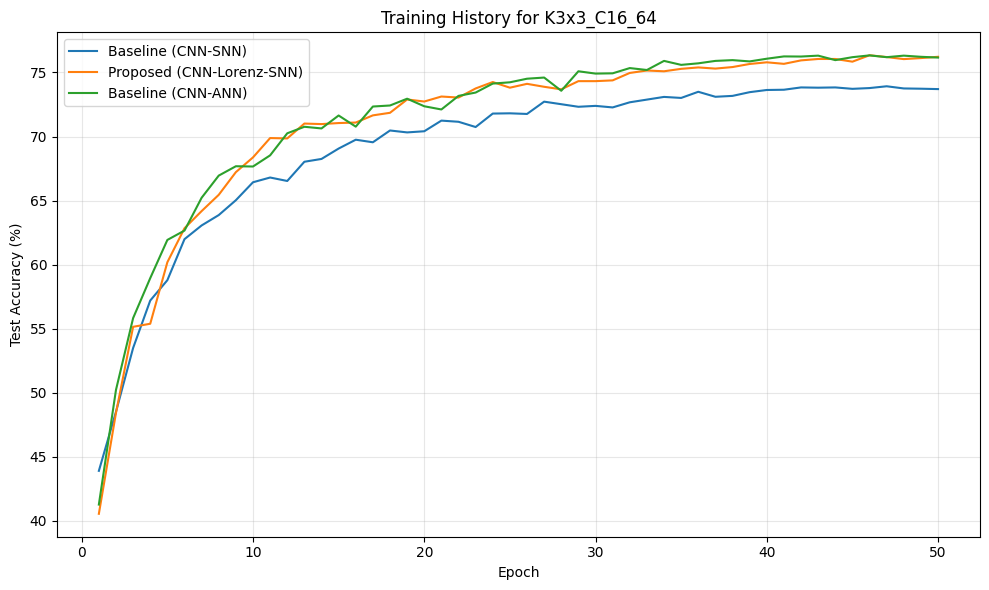

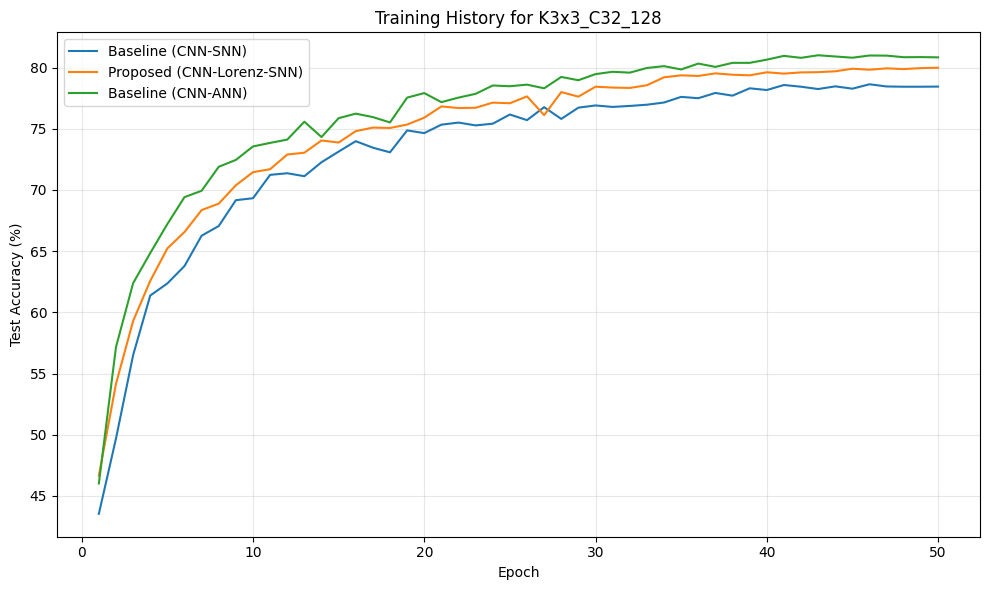

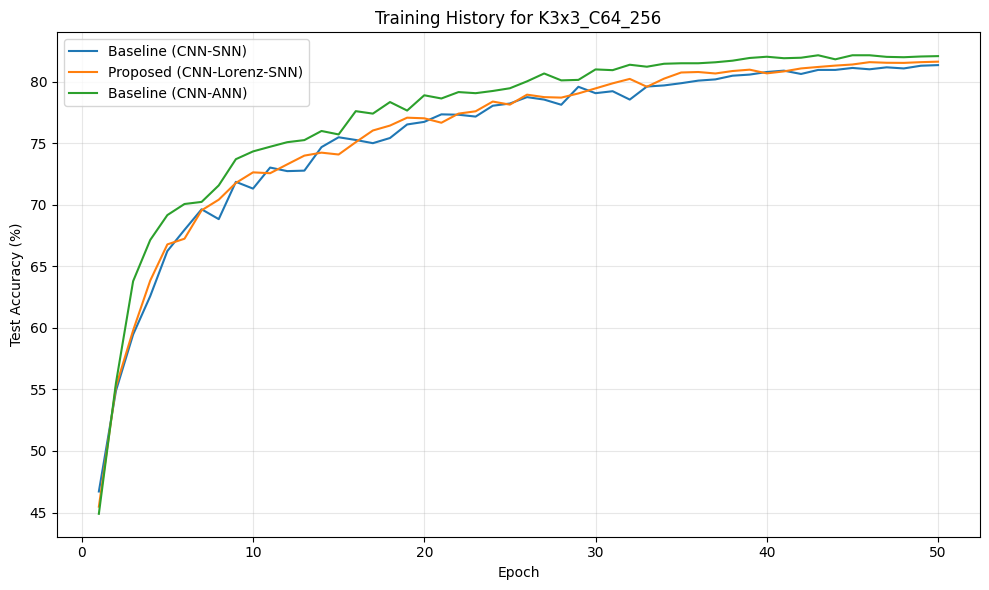

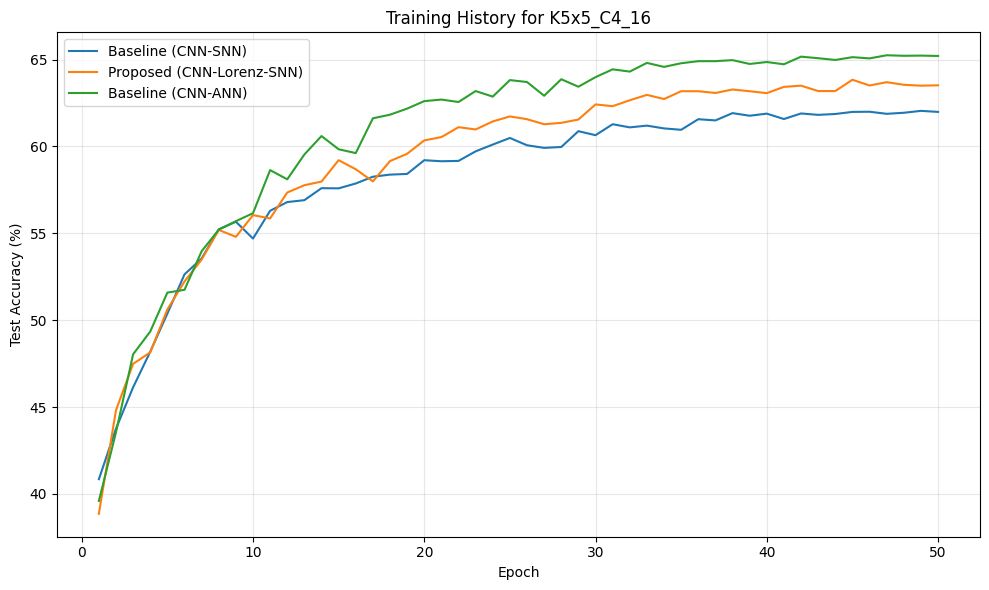

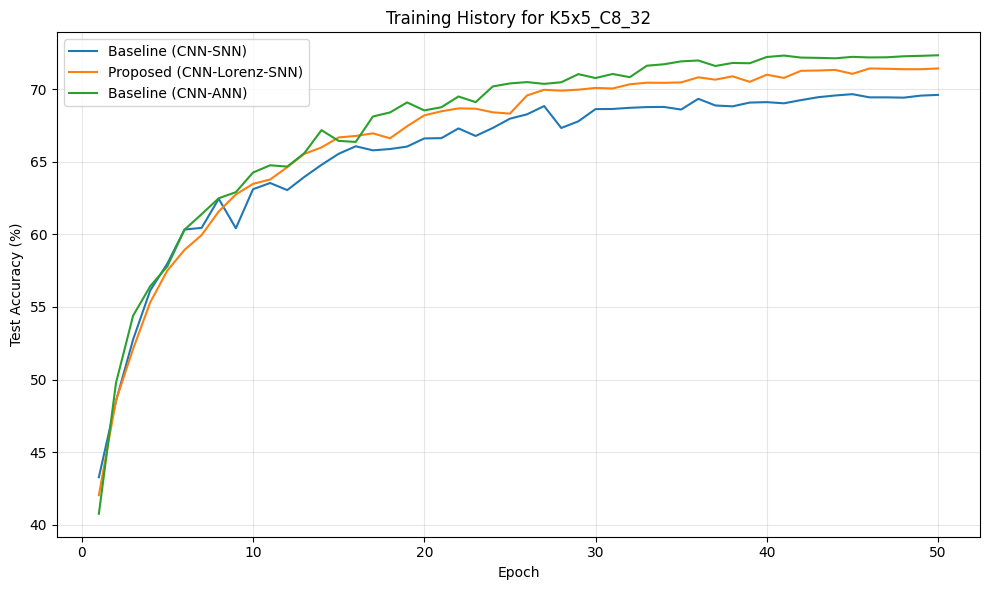

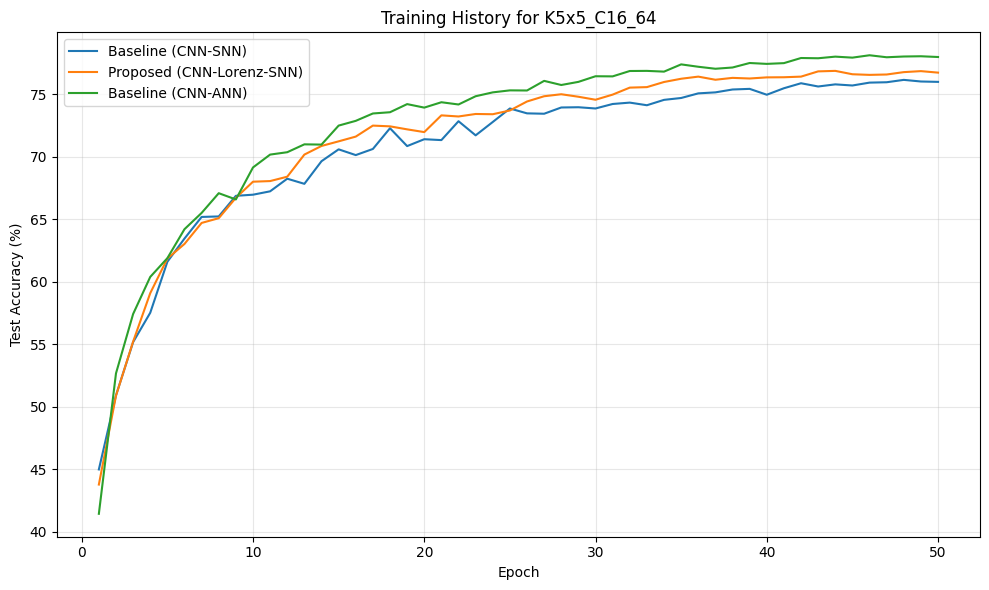

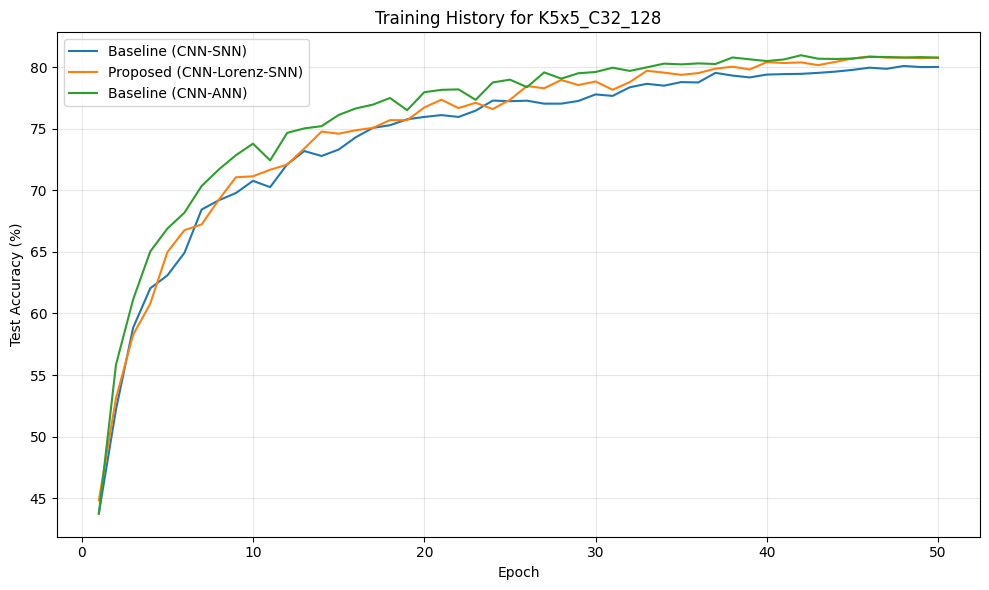

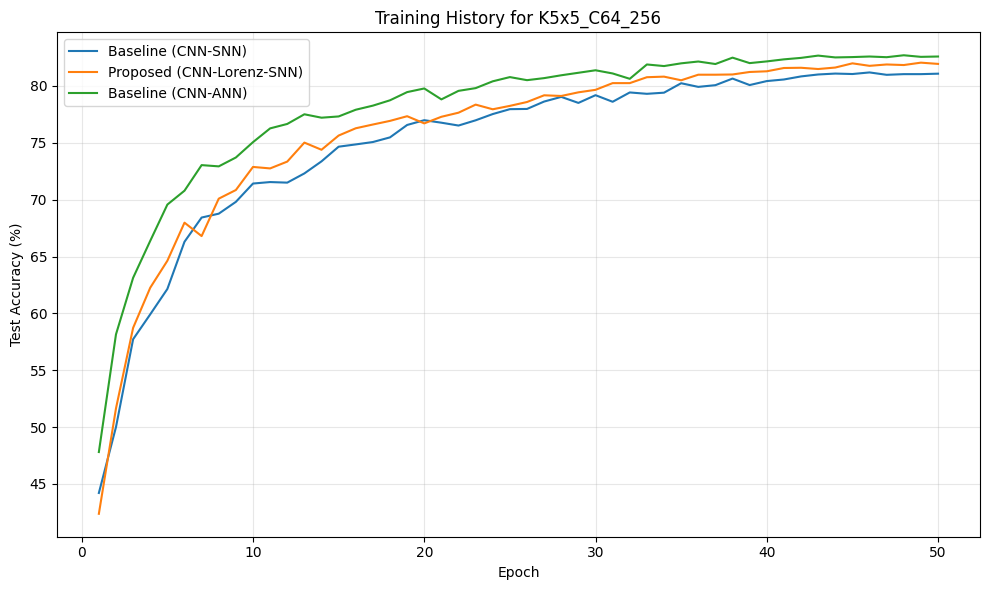

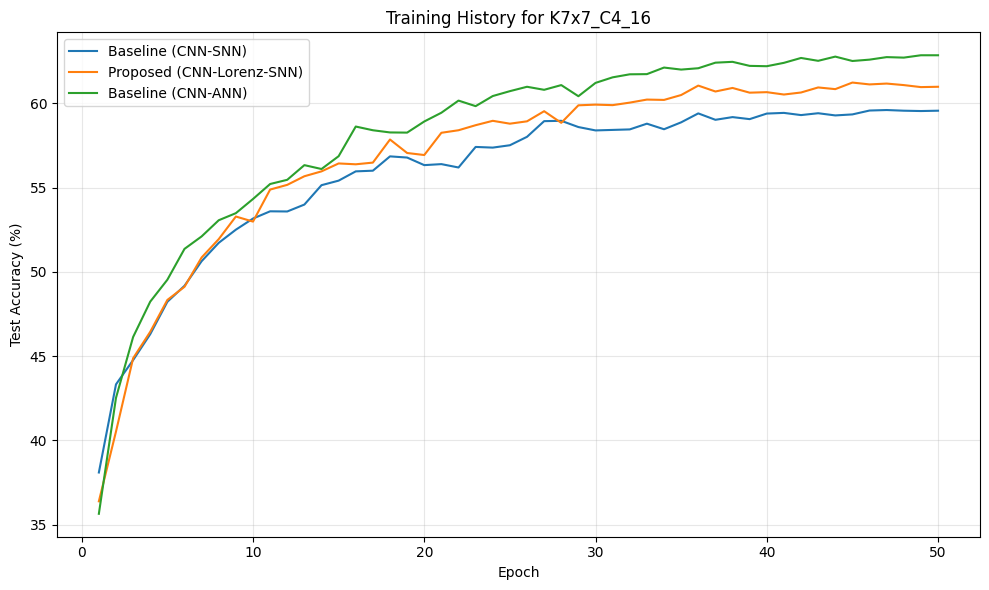

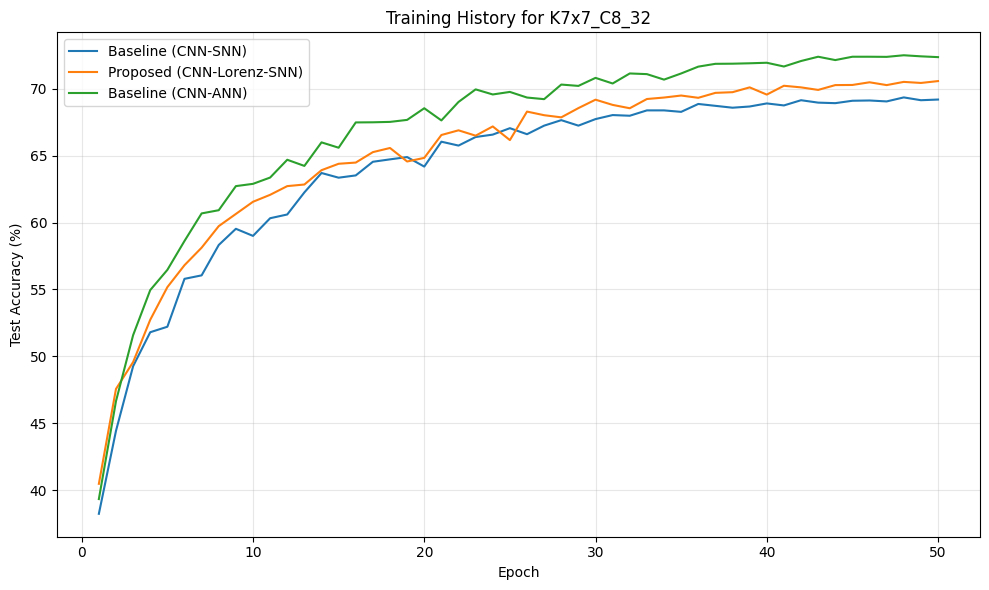

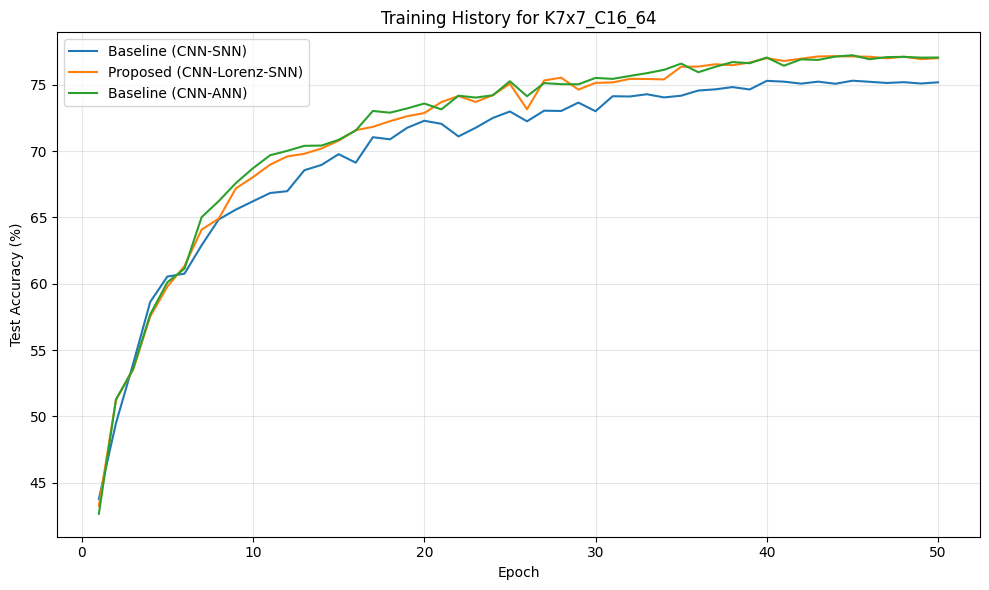

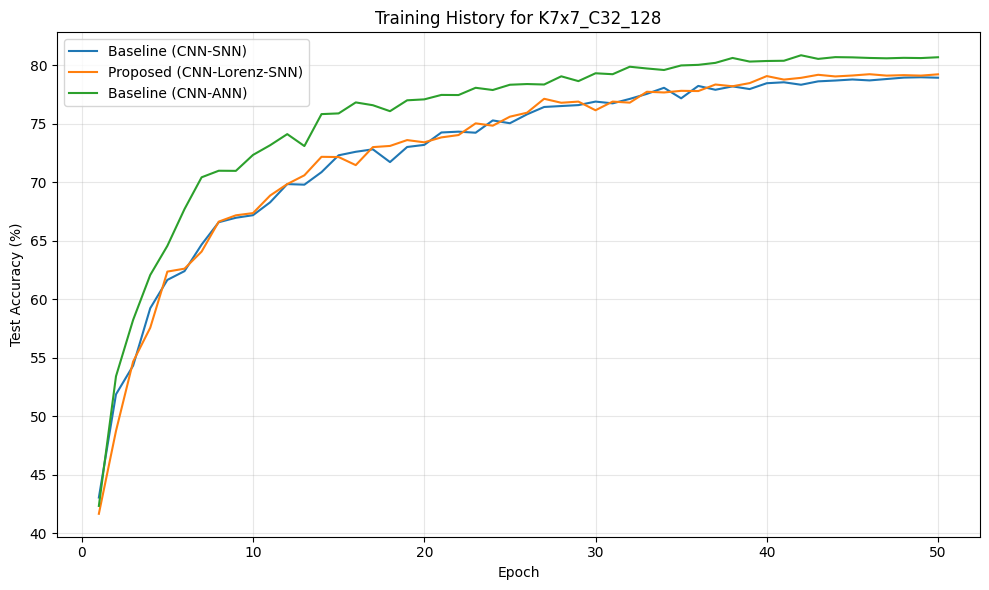

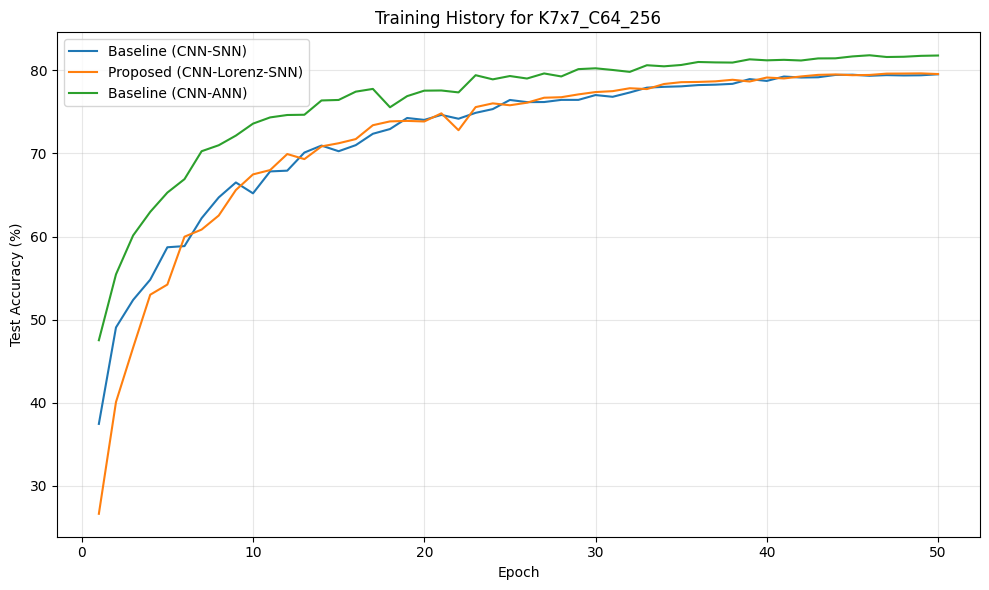


实验完成! 结果保存在 experiment_results 目录中
   Configuration                      Model  Accuracy (%)  Training Time (s)
0     K3x3_C4_16         Baseline (CNN-SNN)         61.10         332.851972
1     K3x3_C4_16  Proposed (CNN-Lorenz-SNN)         63.18         862.878963
2     K3x3_C4_16         Baseline (CNN-ANN)         63.17         194.514546
3     K3x3_C8_32         Baseline (CNN-SNN)         68.89         333.581629
4     K3x3_C8_32  Proposed (CNN-Lorenz-SNN)         70.92         861.617290
5     K3x3_C8_32         Baseline (CNN-ANN)         71.19         197.685792
6    K3x3_C16_64         Baseline (CNN-SNN)         73.92         334.206832
7    K3x3_C16_64  Proposed (CNN-Lorenz-SNN)         76.34         859.465659
8    K3x3_C16_64         Baseline (CNN-ANN)         76.33         197.745010
9   K3x3_C32_128         Baseline (CNN-SNN)         78.63         329.874931
10  K3x3_C32_128  Proposed (CNN-Lorenz-SNN)         79.98         870.555207
11  K3x3_C32_128         Baseline (CNN-A

In [2]:
import torch
import torch.nn as nn
import snntorch as snn
import snntorch.surrogate as surrogate


class Config:
    # dataset
    batch_size = 128
    input_size = 32  # CIFAR-10 image size
    num_classes = 10

    # CNN
    cnn_channels = [3, 24, 128]  
    kernel_sizes = [5, 5]  

    # Lorenz encoding
    chaos_dim = 32
    num_steps = 5 
    sigma = 10.0
    rho = 28.0
    beta = 8 / 3

    # SNN
    beta = 0.95

    # training
    epochs = 50 
    lr = 5e-4
    weight_decay = 1e-4


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
spike_grad = surrogate.fast_sigmoid()

class LorenzTransformRK4(nn.Module):
    """
    Lorenz transform layer uses the RK4 integration method
    """
    def __init__(self, config):
        super().__init__()
        self.num_steps = config.num_steps
        self.sigma = config.sigma
        self.rho = config.rho
        self.beta_param = config.beta
        self.dt = 0.05  
        
    def forward(self, x):
        """Batch processing of Lorenz transforms, using RK4 integration method to improve accuracy"""
        batch_size, dim = x.shape
        device = x.device

        # Initialize the 3D state vector [batch, timesteps, 3*dimensions]
        trajectories = torch.zeros(batch_size, self.num_steps, dim * 3, device=device)

        state = torch.cat([
            x,
            torch.ones_like(x),
            -x
        ], dim=1)  # [B, 3D]

        trajectories[:, 0, :] = state

        # Calculate all time steps using the RK4 method
        for t in range(1, self.num_steps):
            # Decomposing the current state
            x_cur = state[:, :dim]
            y_cur = state[:, dim:2 * dim]
            z_cur = state[:, 2 * dim:]

            # RK4 - K1
            dx1 = self.sigma * (y_cur - x_cur)
            dy1 = x_cur * (self.rho - z_cur) - y_cur
            dz1 = x_cur * y_cur - self.beta_param * z_cur
            k1 = torch.cat([dx1, dy1, dz1], dim=1) * self.dt

            # K2
            x2 = x_cur + k1[:, :dim] / 2
            y2 = y_cur + k1[:, dim:2 * dim] / 2
            z2 = z_cur + k1[:, 2 * dim:] / 2
            dx2 = self.sigma * (y2 - x2)
            dy2 = x2 * (self.rho - z2) - y2
            dz2 = x2 * y2 - self.beta_param * z2
            k2 = torch.cat([dx2, dy2, dz2], dim=1) * self.dt

            # K3
            x3 = x_cur + k2[:, :dim] / 2
            y3 = y_cur + k2[:, dim:2 * dim] / 2
            z3 = z_cur + k2[:, 2 * dim:] / 2
            dx3 = self.sigma * (y3 - x3)
            dy3 = x3 * (self.rho - z3) - y3
            dz3 = x3 * y3 - self.beta_param * z3
            k3 = torch.cat([dx3, dy3, dz3], dim=1) * self.dt

            # K4
            x4 = x_cur + k3[:, :dim]
            y4 = y_cur + k3[:, dim:2 * dim]
            z4 = z_cur + k3[:, 2 * dim:]
            dx4 = self.sigma * (y4 - x4)
            dy4 = x4 * (self.rho - z4) - y4
            dz4 = x4 * y4 - self.beta_param * z4
            k4 = torch.cat([dx4, dy4, dz4], dim=1) * self.dt

            # update state
            state = state + (k1 + 2 * k2 + 2 * k3 + k4) / 6

            # Store the current time step
            trajectories[:, t, :] = state

        return trajectories  # [B, T, 3D]


# CNN-Lorenz-SNN
class CLSNN(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.conv1 = nn.Conv2d(config.cnn_channels[0], config.cnn_channels[1], 
                              kernel_size=config.kernel_sizes[0], padding=2)  
        self.conv2 = nn.Conv2d(config.cnn_channels[1], config.cnn_channels[2], 
                              kernel_size=config.kernel_sizes[1], padding=2) 

        with torch.no_grad():
            dummy = torch.zeros(1, 3, 32, 32)
            x = F.max_pool2d(self.conv1(dummy), 2)
            x = F.max_pool2d(self.conv2(x), 2)
            self.conv_out_flat = x.flatten().shape[0]

        # Projection layer
        self.proj = nn.Linear(self.conv_out_flat, config.chaos_dim)

        # Lorenz
        self.lorenz = LorenzTransformRK4(config)

        # SNN
        self.lif1 = snn.Leaky(beta=config.beta, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=config.beta, spike_grad=spike_grad)

        # Output layer
        self.fc_out = nn.Linear(config.chaos_dim * 3, config.num_classes)

        self.num_steps = config.num_steps

    def forward(self, x):
        # CNN feature extraction
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x)  
        x = F.max_pool2d(self.conv2(x), 2)
        x = F.relu(x)

        x = x.flatten(1)
        x = torch.tanh(self.proj(x))

        # Lorenz
        encoded = self.lorenz(x)

        # SNN
        outputs = []
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        for step in range(self.num_steps):
            cur = encoded[:, step]
            spk1, mem1 = self.lif1(cur, mem1)
            spk2, mem2 = self.lif2(spk1, mem2)
            outputs.append(self.fc_out(mem2))

        return torch.stack(outputs).mean(0)


class BasicCSNN(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Uses the same CNN architecture as CLSNN
        self.conv1 = nn.Conv2d(config.cnn_channels[0], config.cnn_channels[1], 
                              kernel_size=config.kernel_sizes[0], padding=2)
        self.conv2 = nn.Conv2d(config.cnn_channels[1], config.cnn_channels[2], 
                              kernel_size=config.kernel_sizes[1], padding=2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, 32, 32)
            x = F.max_pool2d(self.conv1(dummy), 2)
            x = F.max_pool2d(self.conv2(x), 2)
            self.conv_out_flat = x.flatten().shape[0]

        # Keep the same model structure
        self.proj = nn.Linear(self.conv_out_flat, config.chaos_dim)
        self.lif1 = snn.Leaky(beta=config.beta, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=config.beta, spike_grad=spike_grad)
        self.fc_out = nn.Linear(config.chaos_dim, config.num_classes)
        self.num_steps = config.num_steps

    def forward(self, x):
        # CNN
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x)
        x = F.max_pool2d(self.conv2(x), 2)
        x = F.relu(x)

        x = x.flatten(1)
        x = torch.tanh(self.proj(x))

        # SNN
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        total_mem = 0

        for _ in range(self.num_steps):
            spk1, mem1 = self.lif1(x, mem1)
            spk2, mem2 = self.lif2(spk1, mem2)
            total_mem += self.fc_out(mem2)

        return total_mem / self.num_steps


# Baseline model: CNN-ANN
class BaseCNN(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.conv1 = nn.Conv2d(config.cnn_channels[0], config.cnn_channels[1], 
                              kernel_size=config.kernel_sizes[0], padding=2)
        self.conv2 = nn.Conv2d(config.cnn_channels[1], config.cnn_channels[2], 
                              kernel_size=config.kernel_sizes[1], padding=2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, 32, 32)
            x = F.max_pool2d(self.conv1(dummy), 2)
            x = F.max_pool2d(self.conv2(x), 2)
            self.conv_out_flat = x.flatten().shape[0]

        self.proj = nn.Linear(self.conv_out_flat, config.chaos_dim)
        self.fc1 = nn.Linear(config.chaos_dim, config.chaos_dim)
        self.fc2 = nn.Linear(config.chaos_dim, config.chaos_dim)
        self.classifier = nn.Linear(config.chaos_dim, config.num_classes)

    def forward(self, x):
        # CNN
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x)
        x = F.max_pool2d(self.conv2(x), 2)
        x = F.relu(x)

        x = x.flatten(1)
        x = torch.tanh(self.proj(x))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.classifier(x)

        return x


def forward_pass(net, num_steps, data):
    """Process data for different models."""
    if isinstance(net, BasicCSNN):
        # BasicCSNN
        output = net(data)
        return output.unsqueeze(0), output.unsqueeze(0)
    elif isinstance(net, CLSNN):
        # CLSNN
        output = net(data)
        return output.unsqueeze(0), output.unsqueeze(0)
    else:
        # CNN
        output = net(data)
        return output.unsqueeze(0), output.unsqueeze(0)


def train_and_evaluate(model, train_loader, test_loader, config):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0
    for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            if isinstance(model, BasicCSNN):
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = outputs.max(1)
            elif isinstance(model, CLSNN):
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = outputs.max(1)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = outputs.max(1)

            loss.backward()
            optimizer.step()

            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

        test_acc = evaluate(model, test_loader, config)
        best_acc = max(best_acc, test_acc)

        print(f"Epoch [{epoch + 1}/{config.epochs}] Loss: {total_loss / len(train_loader):.4f} "
              f"Train Acc: {100. * correct / total:.2f}% Test Acc: {test_acc:.2f}%")

        scheduler.step()

    return best_acc


def evaluate(model, loader, config):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            if isinstance(model, (BasicCSNN, CLSNN)):
                outputs = model(images)
                _, predicted = outputs.max(1)
            else:
                outputs = model(images)
                _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100. * correct / total


def load_cifar10(config):

    train_transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    test_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )

    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, pin_memory=True, num_workers=4
    )
    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size, shuffle=False, pin_memory=True, num_workers=4
    )

    return train_loader, test_loader

class ExperimentLogger:
    def __init__(self, output_dir="experiment_results"):
        self.results = {}
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
    def log_config(self, config_name, config):
        """记录配置参数"""
        config_dict = {key: value for key, value in vars(config).items()}
        self.results[config_name] = {
            "config": config_dict,
            "models": {}
        }
        
    def log_model_result(self, config_name, model_name, accuracy, training_time, epochs_history):
        """记录模型结果"""
        if config_name not in self.results:
            self.results[config_name] = {"models": {}}
            
        self.results[config_name]["models"][model_name] = {
            "accuracy": accuracy,
            "training_time": training_time,
            "epochs_history": epochs_history
        }
        
    def save_results(self):
        """保存结果到JSON文件"""
        with open(f"{self.output_dir}/results.json", "w") as f:
            json.dump(self.results, f, indent=4)
            
    def generate_summary_table(self):
        """生成结果汇总表"""
        rows = []
        for config_name, data in self.results.items():
            for model_name, model_data in data["models"].items():
                row = {
                    "Configuration": config_name,
                    "Model": model_name,
                    "Accuracy (%)": model_data["accuracy"],
                    "Training Time (s)": model_data["training_time"]
                }
                rows.append(row)
        
        df = pd.DataFrame(rows)
        df.to_csv(f"{self.output_dir}/summary.csv", index=False)
        return df
    
    def plot_results(self):
        """生成可视化图表"""
        plt.figure(figsize=(14, 8))
        
        configs = list(self.results.keys())
        x = np.arange(len(configs))
        width = 0.25
        
        models = set()
        for config in self.results.values():
            for model in config["models"].keys():
                models.add(model)
        models = sorted(list(models))
        
        for i, model in enumerate(models):
            accuracies = []
            for config in configs:
                if model in self.results[config]["models"]:
                    accuracies.append(self.results[config]["models"][model]["accuracy"])
                else:
                    accuracies.append(0)
            
            plt.bar(x + (i - 1) * width, accuracies, width, label=model)
        
        plt.xlabel('CNN Configuration')
        plt.ylabel('Test Accuracy (%)')
        plt.title('Model Performance Across Different CNN Configurations')
        plt.xticks(x, configs, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/accuracy_comparison.png", dpi=300)
        
        # Plot the gap between models for each configuration
        plt.figure(figsize=(14, 8))
        for config_name in configs:
            if "Proposed (CNN-Lorenz-SNN)" in self.results[config_name]["models"] and "Baseline (CNN-ANN)" in self.results[config_name]["models"]:
                # Calculating the gap between CLSNN and ANN
                clsnn_acc = self.results[config_name]["models"]["Proposed (CNN-Lorenz-SNN)"]["accuracy"]
                ann_acc = self.results[config_name]["models"]["Baseline (CNN-ANN)"]["accuracy"]
                gap_clsnn_ann = ann_acc - clsnn_acc
                
                # Calculating the gap between BasicCSNN and ANN
                if "Baseline (CNN-SNN)" in self.results[config_name]["models"]:
                    basic_snn_acc = self.results[config_name]["models"]["Baseline (CNN-SNN)"]["accuracy"]
                    gap_basic_snn_ann = ann_acc - basic_snn_acc
                    
                    plt.plot([config_name, config_name], [gap_basic_snn_ann, gap_clsnn_ann], 'k-', alpha=0.3)
                    plt.plot(config_name, gap_basic_snn_ann, 'ro', label='BasicCSNN-ANN Gap' if config_name == configs[0] else "")
                
                plt.plot(config_name, gap_clsnn_ann, 'bo', label='CLSNN-ANN Gap' if config_name == configs[0] else "")
                
        plt.axhline(y=0, color='g', linestyle='-', alpha=0.5, label='No Gap Line')
        plt.xlabel('CNN Configuration')
        plt.ylabel('Accuracy Gap (%)')
        plt.title('Performance Gap Between SNN Models and ANN Baseline')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/performance_gap.png", dpi=300)
        
        # Plot the training history for each configuration
        for config_name, config_data in self.results.items():
            plt.figure(figsize=(10, 6))
            for model_name, model_data in config_data["models"].items():
                if "epochs_history" in model_data:
                    epochs = list(range(1, len(model_data["epochs_history"]) + 1))
                    plt.plot(epochs, model_data["epochs_history"], label=model_name)
            
            plt.xlabel('Epoch')
            plt.ylabel('Test Accuracy (%)')
            plt.title(f'Training History for {config_name}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            # plt.savefig(f"{self.output_dir}/{config_name.replace(" ", "-")}_training_history.png", dpi=300)
            plt.close()


def generate_experiment_configs():
    """Generating different CNN configurations"""
    configs = []
    
    base_config = Config()
    
    # Changing the kernel size
    kernel_sizes_options = [(3, 3), (5, 5), (7, 7)]
    
    # Channels
    channel_options = [
        [3, 4, 16],     
        [3, 8, 32],     
        [3, 16, 64],     
        [3, 32, 128],    
        [3, 64, 256]    
    ]
    
    # Combining different kernel_size and channel configurations
    for kernel_sizes, channels in product(kernel_sizes_options, channel_options):
        config = copy.deepcopy(base_config)
        config.kernel_sizes = list(kernel_sizes)
        config.cnn_channels = channels
        
        config_name = f"K{kernel_sizes[0]}x{kernel_sizes[1]}_C{channels[1]}_{channels[2]}"
        configs.append((config_name, config))
    
    return configs

def train_and_evaluate_with_history(model, train_loader, test_loader, config):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0
    history = []
    
    for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            if isinstance(model, BasicCSNN):
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = outputs.max(1)
            elif isinstance(model, CLSNN):
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = outputs.max(1)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = outputs.max(1)

            loss.backward()
            optimizer.step()

            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

        test_acc = evaluate(model, test_loader, config)
        history.append(test_acc)
        best_acc = max(best_acc, test_acc)

        print(f"Epoch [{epoch + 1}/{config.epochs}] Loss: {total_loss / len(train_loader):.4f} "
              f"Train Acc: {100. * correct / total:.2f}% Test Acc: {test_acc:.2f}%")

        scheduler.step()

    return best_acc, history


def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using: {device}")
    
    logger = ExperimentLogger()
    
    experiment_configs = generate_experiment_configs()

    for config_name, config in experiment_configs:
        print(f"\n{'='*50}")
        print(f"Config: {config_name}")
        print(f"{'='*50}")
        
        logger.log_config(config_name, config)
        
        train_loader, test_loader = load_cifar10(config)
        
        models = {
            "Baseline (CNN-SNN)": BasicCSNN(config),
            "Proposed (CNN-Lorenz-SNN)": CLSNN(config),
            "Baseline (CNN-ANN)": BaseCNN(config),
        }
        
        for model_name, model in models.items():
            print(f"\n--- Training {model_name} ---")
            start_time = time.time()
            
            acc, epochs_history = train_and_evaluate_with_history(model, train_loader, test_loader, config)
            
            end_time = time.time()
            training_time = end_time - start_time
            
            print(f"{model_name} Best Accuracy: {acc:.2f}%, Time: {training_time:.2f}s")
            
            logger.log_model_result(config_name, model_name, acc, training_time, epochs_history)
    
    logger.save_results()
    summary_df = logger.generate_summary_table()
    logger.plot_results()
    
    print(summary_df)
    
    return logger


if __name__ == "__main__":
    logger = run_experiment()